# Predicting Redshifts of Galaxies from Photometric Features

To calculate the redshift of a distant galaxy, the most accurate method is to observe the optical emission lines and measure the shift in wavelength. However, this process can be time consuming and is thus infeasible for large samples, so we only have spectrometry measurements for a small fraction of all galaxies that we can see. 

Photometric measurements are easier to obtain (but less accurate). The goal here is to predict the spectroscopic redshift from their photometric colours by training on galaxies for which we have both measurements. This is how the redshift can be calculated for galaxies which have no spectrometric measurements.

In [424]:
import numpy as np
import pandas as pd
import matplotlib as plt

In [425]:
data = np.load('sdss_galaxy_colors.npy')

In [426]:
data

array([(19.84132, 19.52656, 19.46946, 19.17955, 19.10763, b'QSO', 0.539301  , 6.543622e-05),
       (19.86318, 18.66298, 17.84272, 17.38978, 17.14313, b'GALAXY', 0.1645703 , 1.186625e-05),
       (19.97362, 18.31421, 17.47922, 17.0744 , 16.76174, b'GALAXY', 0.04190006, 2.183788e-05),
       ...,
       (19.82667, 18.10038, 17.16133, 16.5796 , 16.19755, b'GALAXY', 0.0784592 , 2.159406e-05),
       (19.98672, 19.75385, 19.5713 , 19.27739, 19.25895, b'QSO', 1.567295  , 4.505933e-04),
       (18.00024, 17.80957, 17.77302, 17.72663, 17.7264 , b'QSO', 0.4749449 , 6.203324e-05)],
      dtype=[('u', '<f8'), ('g', '<f8'), ('r', '<f8'), ('i', '<f8'), ('z', '<f8'), ('spec_class', 'S6'), ('redshift', '<f8'), ('redshift_err', '<f8')])

In [427]:
df = pd.DataFrame(data)

In [428]:
df.head(7)

,u,g,r,i,z,spec_class,redshift,redshift_err
0,19.84132,19.52656,19.46946,19.17955,19.10763,b'QSO',0.539301,0.000065
1,19.86318,18.66298,17.84272,17.38978,17.14313,b'GALAXY',0.164570,0.000012
2,19.97362,18.31421,17.47922,17.07440,16.76174,b'GALAXY',0.041900,0.000022
3,19.05989,17.49459,16.59285,16.09412,15.70741,b'GALAXY',0.044277,0.000011
4,19.45567,18.33084,17.67185,17.30189,17.13650,b'GALAXY',0.041644,0.000018
5,18.27065,18.08745,18.08966,18.22180,18.37045,b'QSO',0.396530,0.056599
6,18.94490,17.45382,16.71061,16.26543,15.94860,b'GALAXY',0.073319,0.000010


Flux magnitudes are the total flux (or light) received in five frequency bands (u, g, r, i and z).

The **colour index** is the difference between the magnitudes of two filters, i.e. u - g or i - z.

This index is one way to characterise the colours of galaxies. For example, if the u-g index is high then the object is brighter in ultra violet frequencies than it is in visible green frequencies.

In [429]:
def get_features(data):
 
   features = np.zeros(shape=(len(data), 4))
   features[:, 0] = data['u'] - data['g']
   features[:, 1] = data['g'] - data['r']
   features[:, 2] = data['r'] - data['i']
   features[:, 3] = data['i'] - data['z']
   targets = data['redshift']
   return features

   pass

data = np.load('sdss_galaxy_colors.npy')
features = get_features(data)

In [430]:
df = pd.DataFrame(features, columns=["u_g", "g_r", "r_i", "i_z"])

In [431]:
df.head()

,u_g,g_r,r_i,i_z
0,0.31476,0.05710,0.28991,0.07192
1,1.20020,0.82026,0.45294,0.24665
2,1.65941,0.83499,0.40482,0.31266
3,1.56530,0.90174,0.49873,0.38671
4,1.12483,0.65899,0.36996,0.16539


In [432]:
df["redshift"]= data["redshift"]

#### The DataFrame to be used to predict redshift:

In [433]:
df.head(7)

,u_g,g_r,r_i,i_z,redshift
0,0.31476,0.05710,0.28991,0.07192,0.539301
1,1.20020,0.82026,0.45294,0.24665,0.164570
2,1.65941,0.83499,0.40482,0.31266,0.041900
3,1.56530,0.90174,0.49873,0.38671,0.044277
4,1.12483,0.65899,0.36996,0.16539,0.041644
5,0.18320,-0.00221,-0.13214,-0.14865,0.396530
6,1.49108,0.74321,0.44518,0.31683,0.073319


In [434]:
Y = df["redshift"]
X = df.drop("redshift", axis=1)

In [435]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.7)

### Decision Tree

In [436]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor()

dtr.fit(X_train, Y_train)

Y_preds = dtr.predict(X_test)

print(predictions[:20])

[1.722355   0.17509147 0.08085633 0.10610242 0.11336521 4.399811
 0.07795616 0.14513644 0.07354285 0.10201892 0.07591395 0.07538214
 0.10835872 1.89579    0.09120796 0.07465717 0.07444315 0.08901572
 0.09479341 0.06717243]


In [437]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(Y_test, Y_preds)

0.09282674011960294

In [438]:
def median_diff(predicted, actual):
  return np.median(np.abs(predicted[:] - actual[:]))

In [439]:
median_diff(Y_preds, Y_test)

0.021755085

### One of the biggest limitations of decision trees is that they tend to over-fit the data. 
In order to see how the tree is overfitting, we would like to examine how our decision tree performs for different **tree depths.** Specifically, we would like to see how it performs on test data compared to the data that was used to train it. 

#### Constraining the number of decision node rows (the tree depth) can have an impact on the accuracy of our predictions.

In [440]:
def accuracy_by_treedepth(features, targets, depths):
  split = features.shape[0]//2
  X_train, X_test = features[:split], features[split:]
  Y_train, Y_test = targets[:split], targets[split:]

  train_diffs = []
  test_diffs = []

  
  for depth in depths:
    dtr = DecisionTreeRegressor(max_depth=depth)
    dtr.fit(X_train, Y_train)
    
    predictions = dtr.predict(X_train)
    train_diffs.append(median_diff(Y_train, predictions))

    predictions = dtr.predict(X_test)
    test_diffs.append(median_diff(Y_test, predictions))
        
  return train_diffs, test_diffs

Depth with lowest median difference : 21


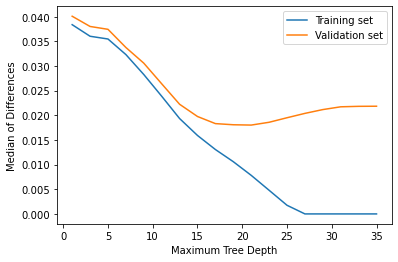

In [441]:
from matplotlib import pyplot as plt

tree_depths = [i for i in range(1, 36, 2)]

train_med_diffs, test_med_diffs = accuracy_by_treedepth(X, Y, tree_depths)
print("Depth with lowest median difference : {}".format(tree_depths[test_med_diffs.index(min(test_med_diffs))]))
    
train_plot = plt.plot(tree_depths, train_med_diffs, label='Training set')
test_plot = plt.plot(tree_depths, test_med_diffs, label='Validation set')
plt.xlabel("Maximum Tree Depth")
plt.ylabel("Median of Differences")
plt.legend()
plt.show()

The accuracy measure of the predictions for the test set gets better initially and then worse at larger tree depths. At a tree depth ~19 the decision tree starts to overfit the data. This means it tries to take into account outliers in the training set and loses its general predictive accuracy.

Overfitting is a common problem with decision trees and can be circumvented by adjusting parameters like the tree depth or setting a minimum number of cases at each node. For now, we will set a **maximum tree depth of 19 to prevent over-fitting.**

In [442]:
dtr = DecisionTreeRegressor(max_depth=19)
dtr.fit(X_train, Y_train)

Y_preds = dtr.predict(X_test)

print(Y_preds[:20])

[0.09021775 0.08666384 0.10242489 0.07661862 0.53938325 0.04585199
 0.07535349 0.06458492 0.10665677 0.06396124 0.09947314 0.0864268
 0.07007905 0.1150927  0.09947314 0.06299949 0.13308175 0.08732733
 0.17951612 0.1113511 ]


In [443]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(Y_test, Y_preds)

0.08676871819758575

In [444]:
def median_diff(predicted, actual):
  return np.median(np.abs(predicted[:] - actual[:]))

In [445]:
median_diff(Y_preds, Y_test)

0.01759415691813902

Clearly, the model has improved by setting max_depth=19.

## K-fold Cross-validation

In [446]:
from sklearn.model_selection import KFold

def cross_validate_model(model, features, targets, k):
  kf = KFold(n_splits=k, shuffle=True)

  diffs = []

  for train_indices, test_indices in kf.split(features):
    train_features, test_features = features[train_indices], features[test_indices]
    train_targets, test_targets = targets[train_indices], targets[test_indices]
    
    model.fit(train_features, train_targets)
    
    predictions = model.predict(test_features)

    diffs.append(median_diff(predictions, test_targets))
 
  return diffs

dtr = DecisionTreeRegressor(max_depth=19)

diffs = cross_validate_model(dtr, features, targets, 10)

print('Differences: {}'.format(', '.join(['{:.3f}'.format(val) for val in diffs])))
print('Mean difference: {:.3f}'.format(np.mean(diffs)))

Differences: 0.017, 0.017, 0.018, 0.017, 0.017, 0.018, 0.018, 0.017, 0.017, 0.018
Mean difference: 0.017


Median difference: 0.017


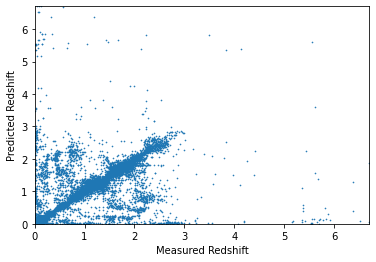

In [447]:
def cross_validate_predictions(model, features, targets, k):
  kf = KFold(n_splits=k, shuffle=True)

  all_predictions = np.zeros_like(targets)

  for train_indices, test_indices in kf.split(features):

    train_features, test_features = features[train_indices], features[test_indices]
    train_targets, test_targets = targets[train_indices], targets[test_indices]
    
    model.fit(train_features, train_targets)
        
    predictions = model.predict(test_features)

    all_predictions[test_indices] = predictions
    
  return all_predictions


if __name__ == "__main__":
  data = np.load('./sdss_galaxy_colors.npy')
  features, targets = get_features_targets(data)


  dtr = DecisionTreeRegressor(max_depth=19)
  predictions = cross_validate_predictions(dtr, features, targets, 10)

  # calculate and print the rmsd as a sanity check
  diffs = median_diff(predictions, targets)
  print('Median difference: {:.3f}'.format(diffs))

  # plot the results to see how well our model looks
  plt.scatter(targets, predictions, s=0.4)
  plt.xlim((0, targets.max()))
  plt.ylim((0, predictions.max()))
  plt.xlabel('Measured Redshift')
  plt.ylabel('Predicted Redshift')
  plt.show()

Clearly, for many our galaxies we were able to get a reasonably accurate prediction of redshift. 
However, there are also several outliers where this model does not give a good prediction.

### This sample of galaxies actually consists of two different populations: regular galaxies and quasi-stellar objects (QSOs). QSOs are a type of galaxy that contain an actively (and intensly) accreting supermassive black hole. This is often referred to as an Active Galactic Nucleus (AGN).

The light emitted from the AGN is significantly brighter than the rest of the galaxy and we are able to detect these QSOs out to much higher redshifts. In fact, most of the normal galaxies have redshifts less than z≈0.4, while the QSOs have redshifts all the way out to z≈6. Due to this contribution from the AGN, the flux magnitudes measured at different wavelengths might not follow the typical profile we assumed when predicting redshifts.

## Difference in the accuracy of the decision trees between QSOs and regular galaxies:

In [448]:
def split_galaxies_qsos(data):
  galaxies = data[data['spec_class'] == b'GALAXY']
  qsos = data[data['spec_class'] == b'QSO']
  return galaxies, qsos

def cross_validate_median_diff(data):
  features, targets = get_features_targets(data)
  dtr = DecisionTreeRegressor(max_depth=19)
  return np.mean(cross_validate_model(dtr, features, targets, 10))


 
galaxies, qsos= split_galaxies_qsos(data)

galaxy_med_diff = cross_validate_median_diff(galaxies)
qso_med_diff = cross_validate_median_diff(qsos)


print("Median difference for Galaxies: {:.3f}".format(galaxy_med_diff))
print("Median difference for QSOs: {:.3f}".format(qso_med_diff))

Median difference for Galaxies: 0.016
Median difference for QSOs: 0.076


So QSOs have a greater median residual ( 
≈
0.074
 ) than the galaxies ( 
≈
0.016
 ). 

This probably happens because:

1. There are far fewer QSOs than galaxies.
2. Galaxies aren't as bright as QSOs so they become too faint to be detected with SDSS at redshifts ≈ 0.4. This creates a measurement bias. 